# NEST implementation of the `aeif` models

#### Hans Ekkehard Plesser and Tanguy Fardet, 2016-09-09, 2024-06-21

This notebook provides a reference solution for the _Adaptive Exponential Integrate and Fire_
(AEIF) neuronal model and compares it with several numerical implementations using simpler solvers.
In particular this justifies the change of implementation in September 2016 to make the simulation
closer to the reference solution.

## NB: NEEDS REVISION — SEE HEP's handwritten notes.

## Position of the problem

### Basics
The equations governing the evolution of the AEIF model are [1]

$$\left\lbrace\begin{array}{rcl}
    C_m\dot{V} &=& -g_L(V-E_L) + g_L \Delta_T e^{\frac{V-V_T}{\Delta_T}} + I_e + I_s(t) -w\\
    \tau_s\dot{w} &=& a(V-E_L) - w
\end{array}\right.$$

when $V < V_{peak}$ (threshold/spike detection).
Once a spike occurs, we apply the reset conditions:

$$V = V_r \quad \text{and} \quad w = w + b$$



### Divergence
In the AEIF model, the spike is generated by the exponential divergence. In practice, this means that just before threshold crossing (threshpassing), the argument of the exponential can become very large.

This is biologically not plausible and can lead to numerical overflow or numerical instabilities in the solver, especially forlarge $V_{peak}$ or small $\Delta_T$.

Brette and Gerstner side-stepped this problem by using forward Euler integration with a fixed time
step [1, 2], and most users of the model seem to have followed this strategy. Then, one will have the largest possible spike current if the
membrane potential is just below the threshold for calling a spike at
the beginning of a time step, i.e., $V_m = V_T + 5\Delta_T$ in
their example. For the parameter values used by Brette and Gerstner,
this gives $I_{\text{spike}}=g_L\Delta_T
e^5=30~\text{nS}\times2~\text{mV}\times e^5\approx 8900~\text{pA}$. Taking into account the membrane capacitance $C=281~\text{pF}$, this corresponds to a rate of change of the membrane potential of $\dot{V}=I_{\text{spike}}/C\approx 32~\text{V}/\text{s}$.

Experimentally, Borst and Sakmann [3] have observed rates of change of the membrane potential of up to $1274~\text{V}/\text{s}$, some 40 times larger than the limit imposed by forward Euler integration and corresponding to $I_{\text{spike}}\approx 360~\text{nF}$.

Below, we explore an exactest possible solution of the actual equations and the effect of limiting the rate of change to $32~\text{V}/\text{s}$ as for forward Euler and to $1274~\text{V}/\text{s}$ as suggested by the data of Borst and Sakmann.

### References

[1] Brette R and Gerstner W (2005). Adaptive exponential
       integrate-and-fire model as an effective description of neuronal
       activity. Journal of Neurophysiology. 943637-3642
       DOI: https://doi.org/10.1152/jn.00686.2005

[2] https://brian2.readthedocs.io/en/stable/examples/frompapers.Brette_Gerstner_2005.html

[3] Borst, J. G. G., & Sakmann, B. (1998). Calcium current during a single action potential in a large presynaptic terminal of the rat brainstem. The Journal of Physiology, 506(1), 143–157. https://doi.org/10.1111/j.1469-7793.1998.143bx.x



## Tested solutions

### Old implementation (before September 2016)
The original solution was to bind the exponential argument to be smaller than 10 (ad hoc value to be close to the original implementation in BRIAN).
As will be shown in the notebook, this solution does not converge to the reference LSODAR solution.

### New implementation
The new implementation does not limit the argument of the exponential, but the rate of change of the potential itself. It does so inside the function evaluating the right-hand side of the membrane-potential equation, so that $\dot{V}$ remains limited in all substeps of the ODE integration.

We will show that this solution is not only closer to the reference solution in general, but also converges towards it as the timestep gets smaller.

## Reference solution

The reference solution is implemented using the LSODAR solver which is described and compared in the following references:

* http://www.radford.edu/~thompson/RP/eventlocation.pdf (papers citing this one)
* http://www.sciencedirect.com/science/article/pii/S0377042712000684
* http://www.radford.edu/~thompson/RP/rootfinding.pdf
* https://computation.llnl.gov/casc/nsde/pubs/u88007.pdf
* http://www.cs.ucsb.edu/~cse/Files/SCE000136.pdf
* http://www.sciencedirect.com/science/article/pii/0377042789903348
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.455.2976&rep=rep1&type=pdf
* https://theses.lib.vt.edu/theses/available/etd-12092002-105032/unrestricted/etd.pdf

## Technical details and requirements

### Implementation of the functions

* The old and new implementations are reproduced using Scipy and are called by the ``scipy_aeif`` function
* The NEST implementations are not shown here, but keep in mind that for a given time resolution, they are closer to the reference result than the scipy implementation since the GSL implementation uses a RK45 adaptive solver.
* The reference solution using LSODAR, called ``reference_aeif``, is implemented through the [assimulo](http://www.jmodelica.org/assimulo) package.

### Requirements

```
mamba create -n assimulo_env "python<3.12" jupyterlab matplotlib numpy assimulo
```

To run this notebook, you need:

* [numpy](http://www.numpy.org/) and [scipy](http://www.scipy.org/)
* [assimulo](http://www.jmodelica.org/assimulo)
* [matplotlib](http://matplotlib.org/)


In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

## Numerical integration of model

### Right-hand side function

Inside the right-hand side function, we limit
- $V$ to $V_{\text{peak}}$, because $V$ never can exceed this value in the model
- $\dot{V}$ to `p.max_dVdt`, which can be configured by the user

In [2]:
def rhs_aeif(y, _, p):
    """
    Parameters
    ----------
    y : list
        Vector containing the state variables [V, w]
    _ : unused var
    p : Params instance
        Object containing the neuronal parameters.

    Returns
    -------
    dv : double
        Derivative of V
    dw : double
        Derivative of w
    """
    
    v = min(y[0], p.Vpeak)
    w = y[1]

    if p.DeltaT != 0.0:
        Ispike = p.gL * p.DeltaT * np.exp((v - p.vT) / p.DeltaT)
    else:
        Ispike = 0

    dv = min(p.max_dVdt, (-p.gL * (v - p.EL) + Ispike - w + p.Ie) / p.Cm)
    dw = (p.a * (v - p.EL) - w) / p.tau_w

    return dv, dw

In [3]:
def rhs_aeif_new(t, y, p):
    """
    Parameters
    ----------
    y : list
        Vector containing the state variables [V, w]
    _ : unused var (t)
    p : Params instance
        Object containing the neuronal parameters.

    Returns
    -------
    dv : double
        Derivative of V
    dw : double
        Derivative of w
    """
    
    v = min(y[0], p.Vpeak)
    w = y[1]

    if p.DeltaT != 0.0:
        Ispike = p.gL * p.DeltaT * np.exp((v - p.vT) / p.DeltaT)
    else:
        Ispike = 0

    dv = min(p.max_dVdt, (-p.gL * (v - p.EL) + Ispike - w + p.Ie*(20<=t<=120)) / p.Cm)
    dw = (p.a * (v - p.EL) - w) / p.tau_w

    return dv, dw

In [4]:
def jac_aeif(y, _, p):
    v = min(y[0], p.Vpeak)
    return np.array([[p.gL/p.Cm*np.expm1((v-p.vT)/p.DeltaT), -1/p.Cm],
    [p.a/p.tau_w, -1/p.tau_w]])

In [5]:
def jac_aeif_new(_, y, p):
    v = min(y[0], p.Vpeak)
    return np.array([[p.gL/p.Cm*np.expm1((v-p.vT)/p.DeltaT), -1/p.Cm],
    [p.a/p.tau_w, -1/p.tau_w]])

### SciPy-based implementation

In [6]:
def euler(p, simtime, dt, mdvdt):
    """
    Complete aeif model using scipy `odeint` solver.

    Parameters
    ----------
    p : Params instance
        Object containing the neuronal parameters.
    simtime : double
        Duration of the simulation (will run between 0 and tmax)
    dt : double
        Time increment.

    Returns
    -------
    t : list
        Times at which the neuronal state was evaluated.
    y : list
        State values associated to the times in `t`
    s : list
        Spike times.
    vs : list
        Values of `V` just before the spike.
    ws : list
        Values of `w` just before the spike
    fos : list
        List of dictionaries containing additional output
        information from `odeint`
    """
    p = copy(p)
    p.max_dVdt = mdvdt
    t = np.arange(0, simtime, dt)  # time axis
    n = len(t)
    y = np.zeros((n, 2))  # V, w
    y[0, :] = (p.EL, p.w)  # Initial: (V_0, w_0) = (E_L, 5.)
    s = []  # spike times
    vs = []  # membrane potential at spike before reset
    ws = []  # w at spike before step
    fos = []  # full output dict from odeint()

    # imitate NEST: update time-step by time-step
    for k in range(1, n):
        y[k, :] = y[k-1, :] + dt * np.array(rhs_aeif_new(t[k-1], y[k-1, :], p))

        # check for threshold crossing
        if y[k, 0] >= p.Vpeak:
            s.append(t[k])
            vs.append(y[k, 0])
            ws.append(y[k, 1])
        
            y[k, 0] = p.Vreset
            y[k, 1] += p.b

    return t, y, s, vs, ws, fos

In [7]:
from copy import copy

In [8]:
def scipy_aeif_new(p, simtime, dt, mdvdt):
    """
    Complete aeif model using scipy `odeint` solver.

    Parameters
    ----------
    p : Params instance
        Object containing the neuronal parameters.
    simtime : double
        Duration of the simulation (will run between 0 and tmax)
    dt : double
        Time increment.

    Returns
    -------
    t : list
        Times at which the neuronal state was evaluated.
    y : list
        State values associated to the times in `t`
    s : list
        Spike times.
    vs : list
        Values of `V` just before the spike.
    ws : list
        Values of `w` just before the spike
    fos : list
        List of dictionaries containing additional output
        information from `odeint`
    """
    p = copy(p)
    p.max_dVdt = mdvdt
    t = np.arange(0, simtime, dt)  # time axis
    n = len(t)
    y = np.zeros((n, 2))  # V, w
    y[0, :] = (p.EL, p.w)  # Initial: (V_0, w_0) = (E_L, 5.)
    s = []  # spike times
    vs = []  # membrane potential at spike before reset
    ws = []  # w at spike before step
    fos = []  # full output dict from odeint()

    ev = lambda _, y, p: y[0] - p.Vpeak
    ev.terminal = True
    ev.direction = 1

    t_all, v_all, w_all = [], [], []
    t_old, w_old = 0, y[0, 1]
    while True:
        res = solve_ivp(rhs_aeif_new, [t_old, simtime+1], (p.Vreset if t_old > 0 else y[0, 0], w_old), method='LSODA',
                  args=[p], jac=jac_aeif_new, events=ev)
        t_old = res.t[-1]
        w_old = res.y[1, -1] + p.b
        t_all.extend(res.t)
        v_all.extend(res.y[0, :])
        w_all.extend(res.y[1, :])
        if res.t_events[0].size > 0:
            s.append(res.t_events[0][0])
        if res.t[-1] >= simtime:
            break
    
    #return t, y, s, vs, ws, fos
    return t_all, v_all, w_all, res, s

## Set the parameters and simulate the models
### Params (chose a dictionary)

In [9]:
# Regular spiking
aeif_param1 = {
    "V_reset": -70.6,
    "V_peak": -40.4,
    "V_th": -50.4,
    "I_e": 1000.0,
    "g_L": 30.0,
    "tau_w": 144.0,
    "E_L": -70.6,
    "Delta_T": 2.0,
    "a": 4.0,
    "b": 80.5,
    "C_m": 281.0,
    "V_m": -70.6,  #! must be equal to E_L
    "w": 0,  #! must be equal to 5.
    "tau_syn_ex": 0.2,
    #"max_dVdt": np.inf,
}

# Bursting
aeif_param = {
    "V_reset": -45.4,
    "V_peak": -40.4,
    "V_th": -50.4,
    "I_e": 1000.0,
    "g_L": 30.0,
    "tau_w": 20.0,
    "E_L": -70.6,
    "Delta_T": 2.0,
    "a": 4.0,
    "b": 500,
    "C_m": 281.0,
    "V_m": -70.6,  #! must be equal to E_L
    "w": 0.0,  #! must be equal to 5.
    "tau_syn_ex": 0.2,
}

# Fast spiking
aeif_param3 = {
        "V_reset": -70.6,
    "V_peak": -40.4,
    "V_th": -50.4,
    "I_e": 1000.0,
    "g_L": 30.0,
    "tau_w": 144.0,
    "E_L": -70.6,
    "Delta_T": 2.0,
    "a": 2*281/144,  # 2C/tau_w
    "b": 0,
    "C_m": 281.0,
    "V_m": -70.6,  #! must be equal to E_L
    "w": 0, # 5.0,  #! must be equal to 5.
    "tau_syn_ex": 0.2,
}


class Params:
    """
    Class giving access to the neuronal
    parameters.
    """

    def __init__(self):
        self.params = aeif_param
        self.Vpeak = aeif_param["V_peak"]
        self.Vreset = aeif_param["V_reset"]
        self.gL = aeif_param["g_L"]
        self.Cm = aeif_param["C_m"]
        self.EL = aeif_param["E_L"]
        self.DeltaT = aeif_param["Delta_T"]
        self.tau_w = aeif_param["tau_w"]
        self.a = aeif_param["a"]
        self.b = aeif_param["b"]
        self.vT = aeif_param["V_th"]
        self.Ie = aeif_param["I_e"]
        self.w = aeif_param["w"]
        #self.max_dVdt = aeif_param["max_dVdt"]


p = Params()

### Simulate the 3 implementations

In [16]:
t, v, w, r, s = scipy_aeif_new(p, 500, 0.1, 1200)
ti, vi, wi, ri, si = scipy_aeif_new(p, 500, 0.1, np.inf)
q = copy(p)
q.Vpeak = 0
tq, vq, wq, rq, sq = scipy_aeif_new(q, 500, 0.1, np.inf)
c = copy(p)
c.Vpeak = p.vT + p.DeltaT * np.log(p.Cm * 1200/(p.gL * p.DeltaT))
tc, vc, wc, rc, sc = scipy_aeif_new(c, 500, 0.1, np.inf)

In [17]:
resl = euler(p, 500, 0.1, np.inf)
resh = euler(p, 500, 0.01, np.inf)

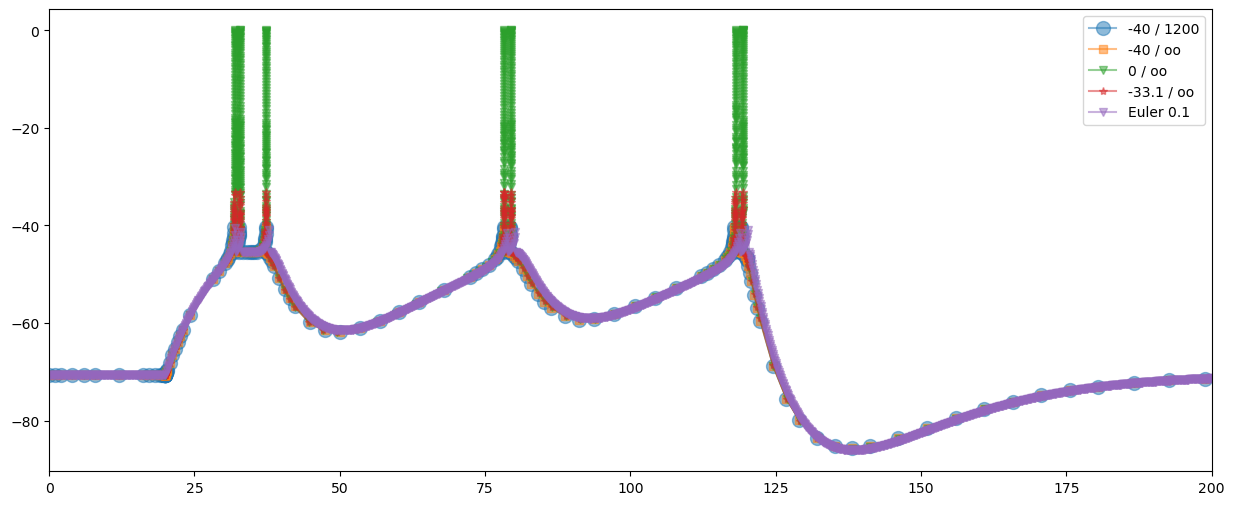

In [22]:
plt.plot(t, v, 'o-', label='-40 / 1200', alpha=0.5, ms=10);
plt.plot(ti, vi, 's-', label='-40 / oo', alpha=0.5);
plt.plot(tq, vq, 'v-', label='0 / oo', alpha=0.5);
plt.plot(tc, vc, '*-', label=f'{c.Vpeak:.1f} / oo', alpha=0.5);
plt.plot(resl[0], resl[1][:, 0], 'v-', label='Euler 0.1', alpha=0.5);
#plt.plot(resh[0], resh[1][:, 0], 'v-', label='Euler 0.01', alpha=0.5);
plt.legend();
plt.xlim(0, 200);
#plt.xlim(31.898, 31.9005);
#plt.ylim(-50, 1);

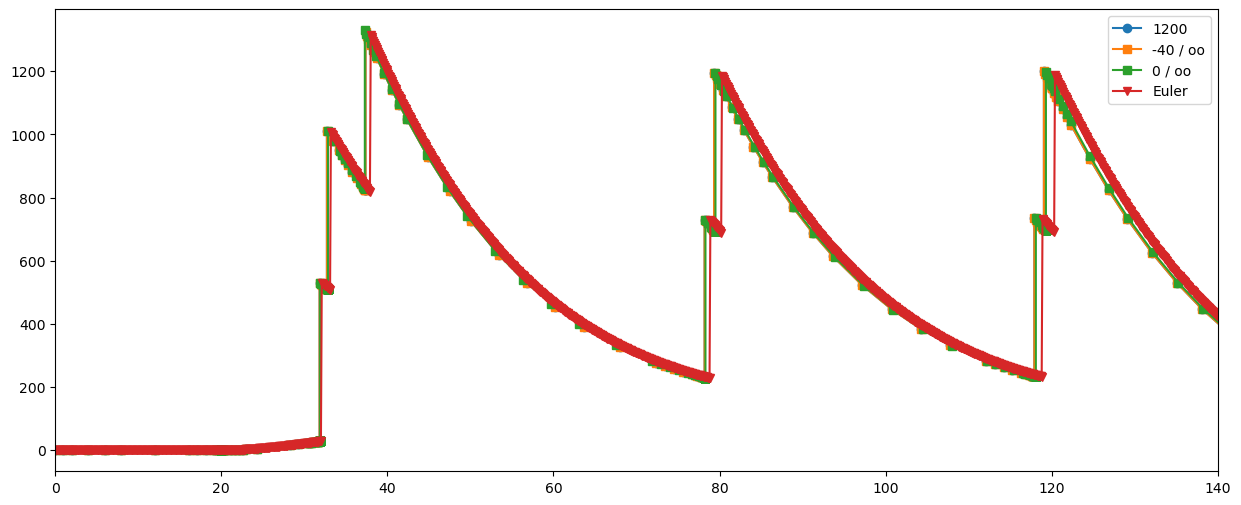

In [14]:
plt.plot(t, w, 'o-', label='1200');
plt.plot(ti, wi, 's-', label='-40 / oo');
plt.plot(tq, wq, 's-', label='0 / oo');
plt.plot(resl[0], resl[1][:, 1], 'v-', label='Euler');
plt.legend();
plt.xlim(0, 140);
#plt.ylim(45, 50);

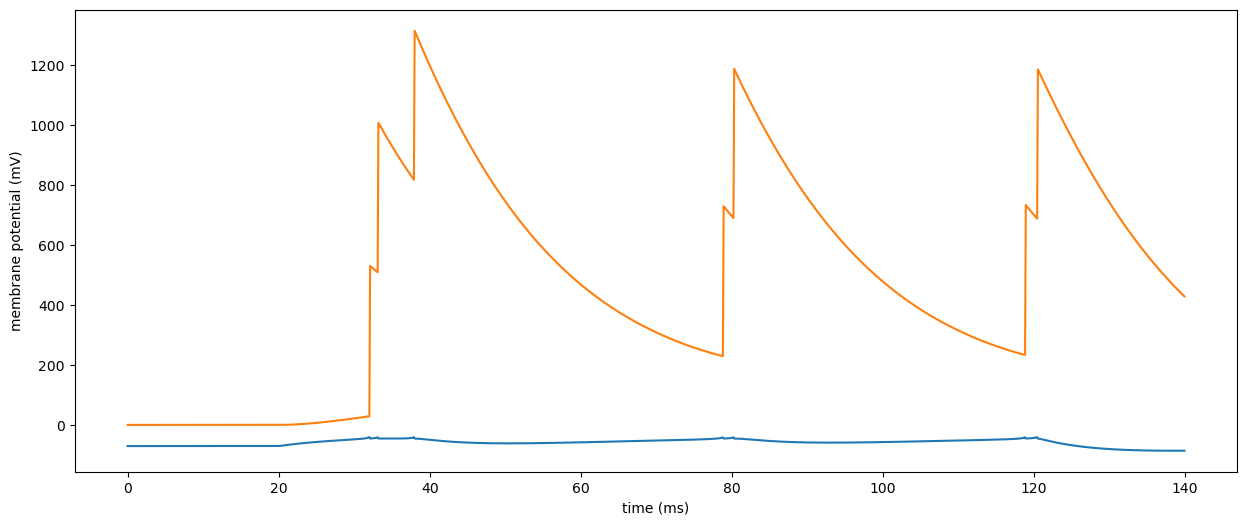

<Figure size 1500x600 with 0 Axes>

In [15]:
%run Brette_Gerstner_2005.py

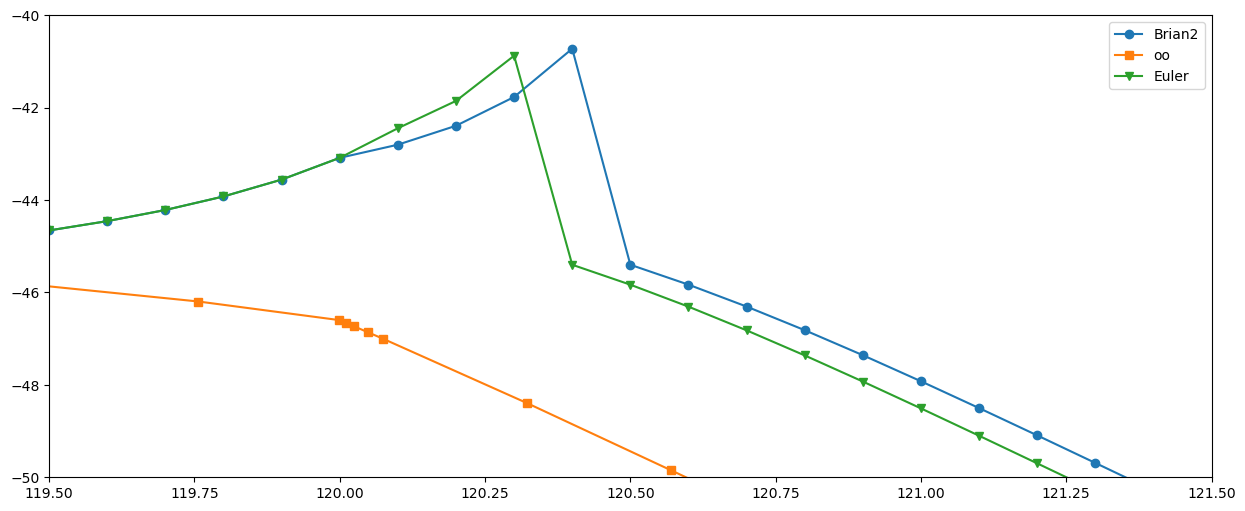

In [40]:
plt.plot(trace.t/ms, vm/mV, 'o-', label='Brian2');
plt.plot(ti, vi, 's-', label='oo');
plt.plot(resl[0], resl[1][:, 0], 'v-', label='Euler');
plt.legend();
plt.xlim(119.5, 121.5);
plt.ylim(-50, -40);

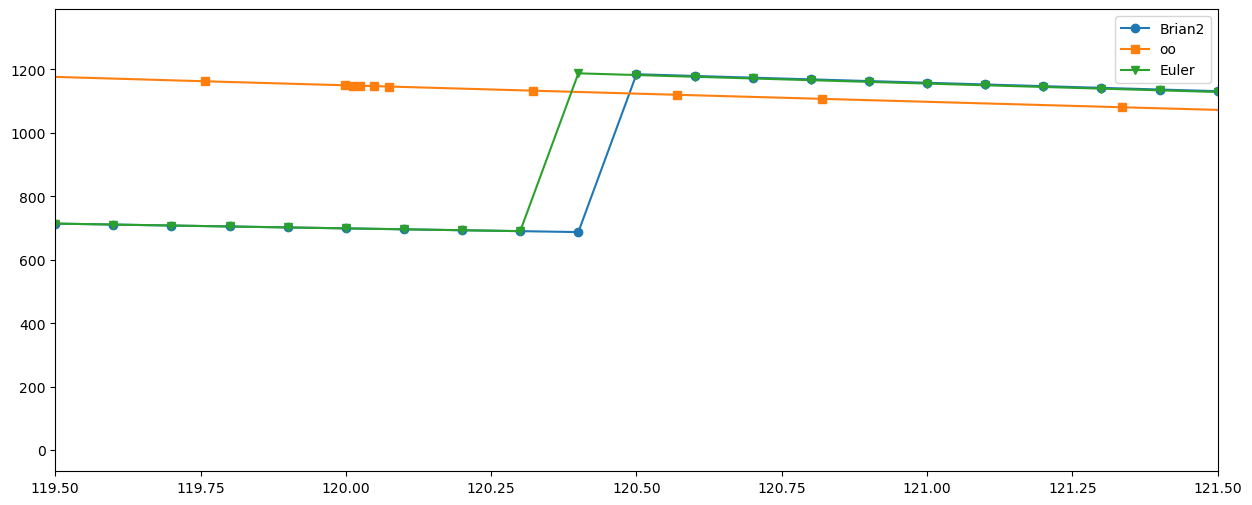

In [41]:
plt.plot(tracew.t/ms, tracew[0].w/pA, 'o-', label='Brian2');
plt.plot(ti, wi, 's-', label='oo');
plt.plot(resl[0], resl[1][:, 1], 'v-', label='Euler');
plt.legend();
plt.xlim(119.5, 121.5);
#plt.ylim(-50, -40);

In [17]:
tracew[0].w[195:205]/pA

array([0.00012946, 0.00013021, 0.00013096, 0.0001317 , 0.00013244,
       0.00013318, 0.00013392, 0.00725209, 0.02137613, 0.04239578])

In [18]:
nti = np.array(ti)
np.array(wi)[(nti>19.5)&(nti<20.5)]

array([0.0001304 , 0.00013228, 0.00013275, 0.00013278, 0.00013281,
       0.00013282, 0.00013295, 0.0001336 , 0.00013503, 0.00013511,
       0.00013519, 0.00013528, 0.00013622, 0.00013732, 0.00013856,
       0.00015935, 0.00019526, 0.00024628, 0.00031241, 0.00180199,
       0.00478997, 0.00926549, 0.0152178 , 0.02263616])

In [19]:
resl[1][195:205, 1]-tracew[0].w[195:205]/pA

array([7.99106874e-14, 7.96377124e-14, 7.93572022e-14, 7.89626340e-14,
       7.88076202e-14, 7.87977268e-14, 7.88877969e-14, 7.88214979e-14,
       7.88258347e-14, 7.88188959e-14])

In [20]:
wb = tracew[0].w/pA
tb = tracew.t/ms

In [34]:
dV = vm[:1400]/mV - resl[1][:1400, 0]
dw = wb[:1400] - resl[1][:1400, 1]

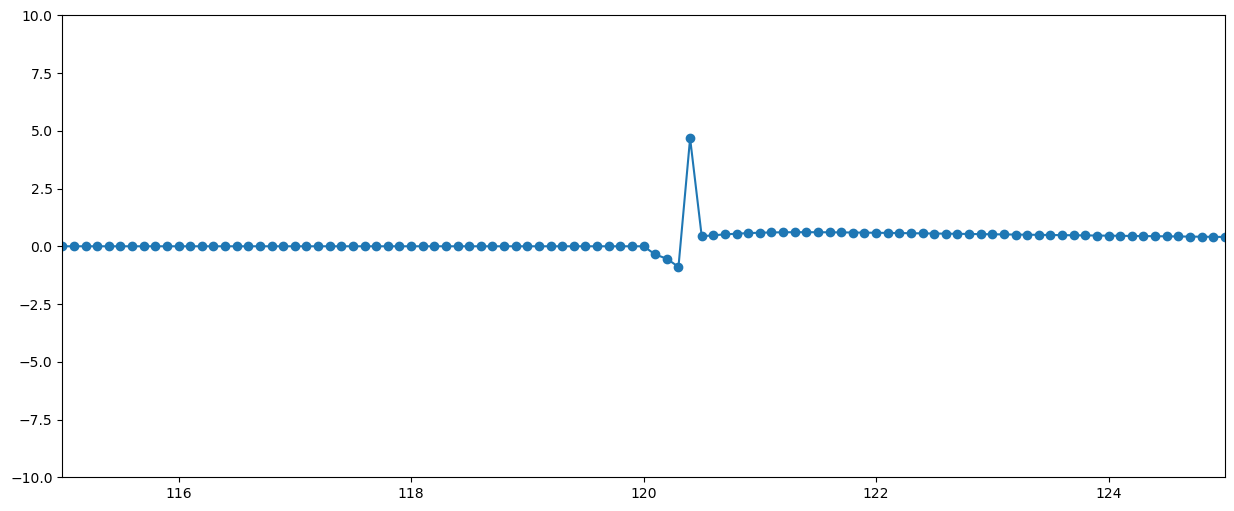

In [38]:
plt.plot(tb[:1400], dV, 'o-')
#plt.plot(tb[:1400], dw, 'x-')
plt.xlim(115, 125);
plt.ylim(-10, 10);

In [ ]:
plt.plot

In [23]:
np.array(s).T

array([ 31.83924706,  32.71997315,  37.36716677,  78.20548778,
        79.34671447, 117.91752604, 119.0670604 ])

In [24]:
np.array(si).T

array([ 31.83924706,  32.71997315,  37.36716677,  78.20548778,
        79.34671447, 117.91752604, 119.0670604 ])

In [25]:
np.array(sq).T

array([ 31.89998622,  32.84322467,  37.28548096,  78.30767084,
        79.51204997, 118.09670885, 119.30997558])

In [26]:
np.array(sc).T

array([ 31.8983754 ,  32.84000459,  37.28565313,  78.30434524,
        79.50714913, 118.0912996 , 119.3029256 ])

In [27]:
np.ceil(np.array(sc).T*10)/10

array([ 31.9,  32.9,  37.3,  78.4,  79.6, 118.1, 119.4])

In [28]:
spikes.event_trains()

{0: array([ 32. ,  33.1,  37.9,  78.8,  80.2, 118.8, 120.4]) * msecond}

In [29]:
np.array(resl[2]).T

array([ 32.1,  33.2,  38. ,  78.9,  80.3, 118.9, 120.4])

In [30]:
vm[trace.t/ms == 1204]

array([], dtype=float64) * volt

In [31]:
trace.t[1204]

120.4 * msecond

In [32]:
k = 1204; vm[k:k+2]

array([-40.72394134, -45.4       ]) * mvolt

In [45]:
trace.t[679]

67.9 * msecond

## Plot the results
### Zoom out

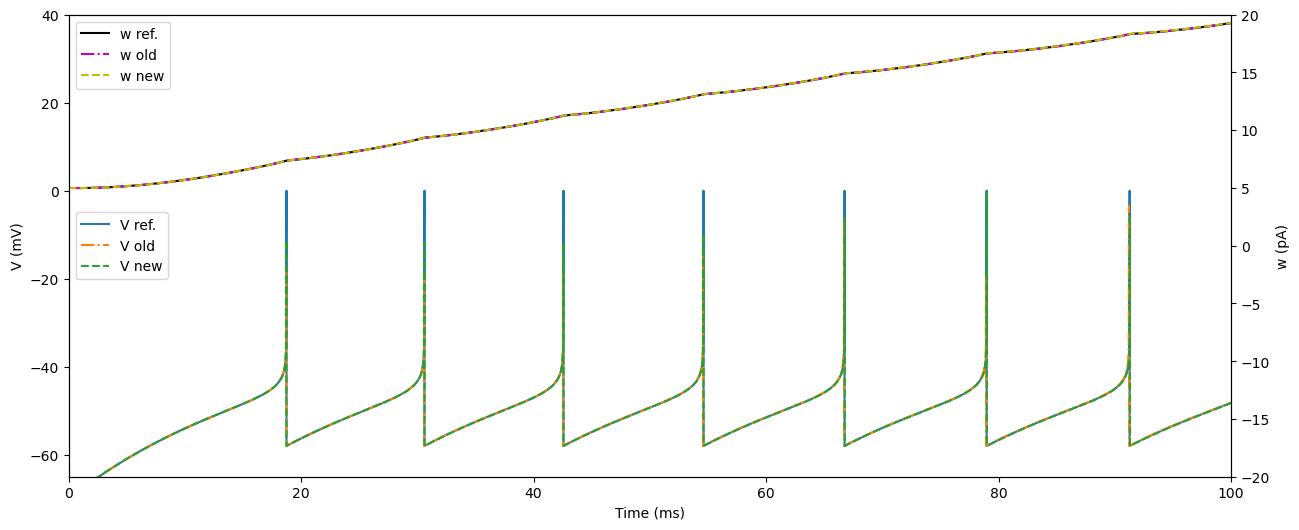

In [13]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

# Plot the potentials
ax.plot(t_ref, y_ref[:, 0], linestyle="-", label="V ref.")
ax.plot(t_old, y_old[:, 0], linestyle="-.", label="V old")
ax.plot(t_new, y_new[:, 0], linestyle="--", label="V new")

# Plot the adaptation variables
ax2.plot(t_ref, y_ref[:, 1], linestyle="-", c="k", label="w ref.")
ax2.plot(t_old, y_old[:, 1], linestyle="-.", c="m", label="w old")
ax2.plot(t_new, y_new[:, 1], linestyle="--", c="y", label="w new")

# Show
ax.set_xlim([0.0, simtime])
ax.set_ylim([-65.0, 40.0])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V (mV)")
ax2.set_ylim([-20.0, 20.0])
ax2.set_ylabel("w (pA)")
ax.legend(loc=6)
ax2.legend(loc=2)
plt.show()

### Zoom in

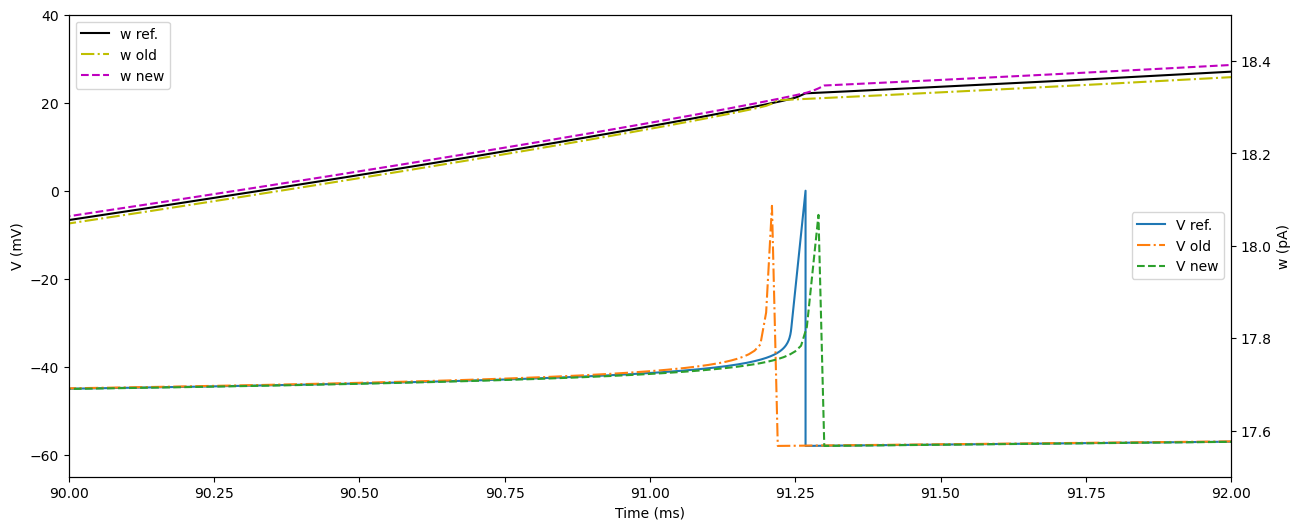

In [14]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

# Plot the potentials
ax.plot(t_ref, y_ref[:, 0], linestyle="-", label="V ref.")
ax.plot(t_old, y_old[:, 0], linestyle="-.", label="V old")
ax.plot(t_new, y_new[:, 0], linestyle="--", label="V new")

# Plot the adaptation variables
ax2.plot(t_ref, y_ref[:, 1], linestyle="-", c="k", label="w ref.")
ax2.plot(t_old, y_old[:, 1], linestyle="-.", c="y", label="w old")
ax2.plot(t_new, y_new[:, 1], linestyle="--", c="m", label="w new")

ax.set_xlim([90.0, 92.0])
ax.set_ylim([-65.0, 40.0])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V (mV)")
ax2.set_ylim([17.5, 18.5])
ax2.set_ylabel("w (pA)")
ax.legend(loc=5)
ax2.legend(loc=2)
plt.show()

### Compare properties at spike times

In [15]:
print("spike times:\n-----------")
print("ref", np.around(s_ref, 3))  # ref lsodar
print("old", np.around(s_old, 3))
print("new", np.around(s_new, 3))

print("\nV at spike time:\n---------------")
print("ref", np.around(vs_ref, 3))  # ref lsodar
print("old", np.around(vs_old, 3))
print("new", np.around(vs_new, 3))

print("\nw at spike time:\n---------------")
print("ref", np.around(ws_ref, 3))  # ref lsodar
print("old", np.around(ws_old, 3))
print("new", np.around(ws_new, 3))

spike times:
-----------
ref [18.74  30.662 42.617 54.614 66.747 78.977 91.278]
old [18.73 30.59 42.54 54.58 66.71 78.92 91.22]
new [18.74 30.61 42.57 54.62 66.76 78.99 91.3 ]

V at spike time:
---------------
ref [ 1.929 69.364 65.604  1.197  0.91  15.346 12.886]
old [ 6.128  5.615  6.107 10.186 17.895  4.997 20.766]
new [ 1.408  0.856  0.845  2.734  6.556 12.31   7.248]

w at spike time:
---------------
ref [ 7.372  9.407 11.321 13.126 14.92  16.663 18.337]
old [ 7.367  9.344 11.258 13.111 14.906 16.637 18.315]
new [ 7.372  9.354 11.272 13.129 14.927 16.667 18.347]


### Size of minimal integration timestep

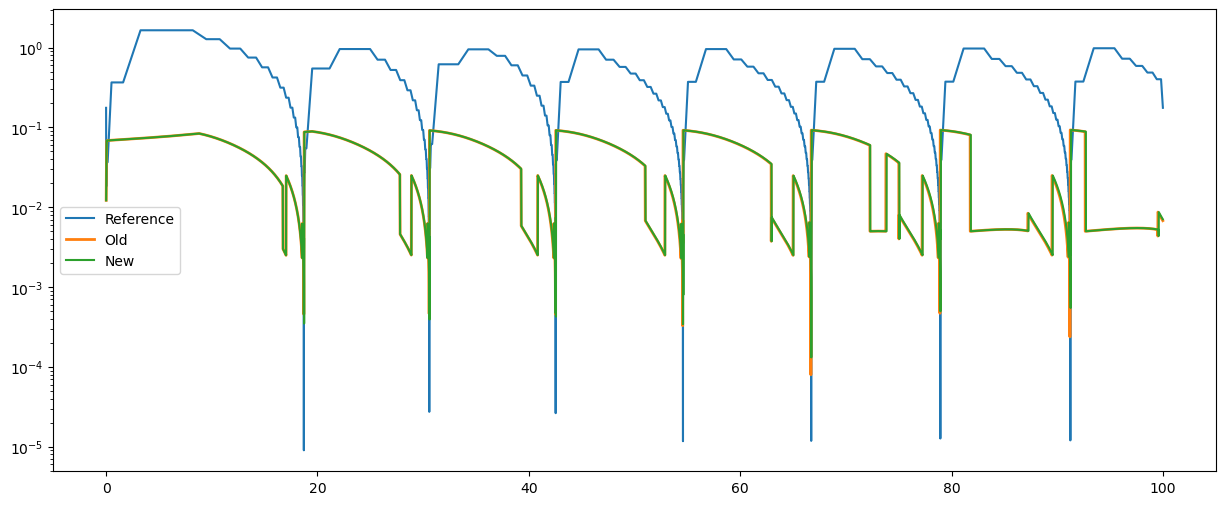

In [16]:
plt.semilogy(t_ref, h_ref, label="Reference")
plt.semilogy(t_old[1:], [d["hu"] for d in fo_old], linewidth=2, label="Old")
plt.semilogy(t_new[1:], [d["hu"] for d in fo_new], label="New")

plt.legend(loc=6)
plt.show();

## Convergence towards LSODAR reference with step size
### Zoom out

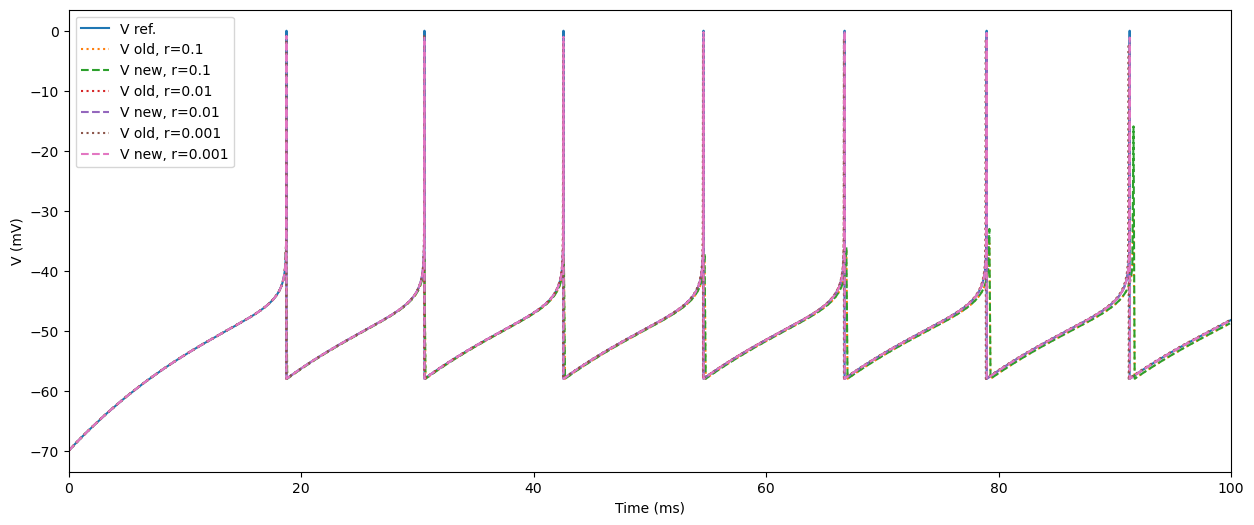

In [17]:
plt.plot(t_ref, y_ref[:, 0], label="V ref.")
resolutions = (0.1, 0.01, 0.001)
di_res = {}

for resolution in resolutions:
    t_old, y_old, _, _, _, _ = scipy_aeif(p, rhs_aeif_old, simtime, resolution)
    t_new, y_new, _, _, _, _ = scipy_aeif(p, rhs_aeif_new, simtime, resolution)
    di_res[resolution] = (t_old, y_old, t_new, y_new)
    plt.plot(t_old, y_old[:, 0], linestyle=":", label="V old, r={}".format(resolution))
    plt.plot(t_new, y_new[:, 0], linestyle="--", linewidth=1.5, label="V new, r={}".format(resolution))
plt.xlim(0.0, simtime)
plt.xlabel("Time (ms)")
plt.ylabel("V (mV)")
plt.legend(loc=2)
plt.show();

### Zoom in

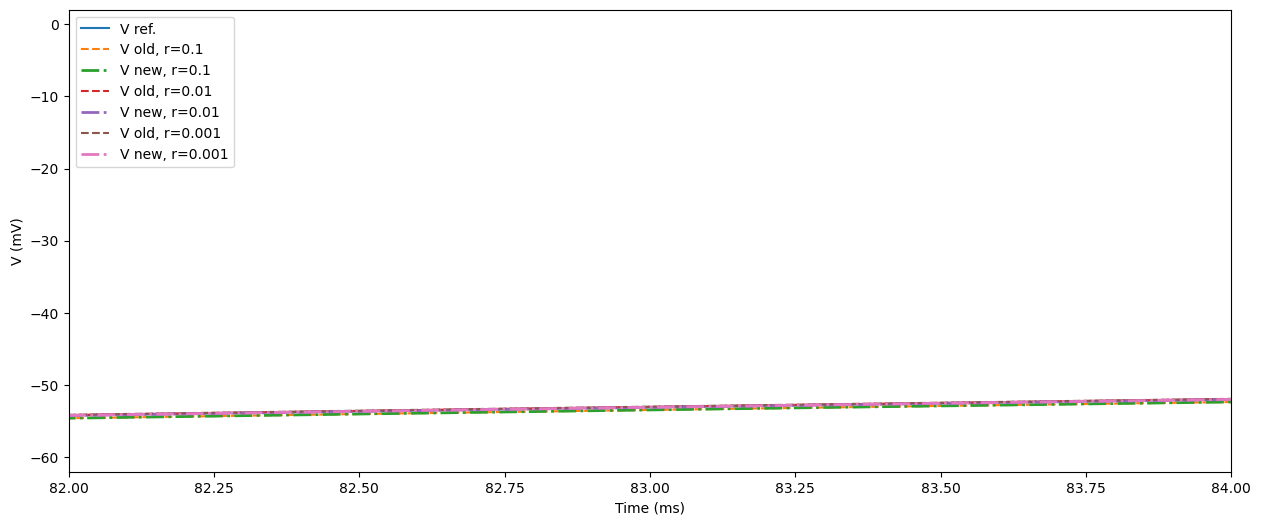

In [18]:
plt.plot(t_ref, y_ref[:, 0], label="V ref.")
for resolution in resolutions:
    t_old, y_old = di_res[resolution][:2]
    t_new, y_new = di_res[resolution][2:]
    plt.plot(t_old, y_old[:, 0], linestyle="--", label="V old, r={}".format(resolution))
    plt.plot(t_new, y_new[:, 0], linestyle="-.", linewidth=2.0, label="V new, r={}".format(resolution))
plt.xlim(82.0, 84.0)
plt.ylim([-62.0, 2.0])
plt.xlabel("Time (ms)")
plt.ylabel("V (mV)")
plt.legend(loc=2)
plt.show();

-----------------------------
### License

This file is part of NEST. Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.